In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy
import ipywidgets as widgets
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

def freedman(data):
    # freedman method for choosing no of bins
    data = np.asarray(data, dtype=np.float_)
    IQR = scipy.stats.iqr(data, rng=(25, 75), scale=1, nan_policy="omit")
    N = data.size
    bw = (2 * IQR) / np.power(N, 1/3)
    mini= np.min(data)
    maxi=np.max(data)
    d = maxi-mini
    result = int((d / bw) + 1)
    return result

In [2]:
# loading all csv files using pandas
PATH = '../datasets/'
Study_A = pd.read_csv(PATH+"Study_A.csv")
Study_B = pd.read_csv(PATH+"Study_B.csv")
Study_C = pd.read_csv(PATH+"Study_C.csv")
Study_D = pd.read_csv(PATH+"Study_D.csv")
Study_E = pd.read_csv(PATH+"Study_E.csv") 

In [3]:
all_studies = pd.concat([Study_A,Study_B,Study_C,Study_D,Study_E]) 
# considering all given studies as we have data of PANSS_Score and visit days for all studies 

In [4]:
all_studies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22909 entries, 0 to 1961
Data columns (total 40 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Study         22909 non-null  object
 1   Country       22909 non-null  object
 2   PatientID     22909 non-null  int64 
 3   SiteID        22909 non-null  int64 
 4   RaterID       22909 non-null  int64 
 5   AssessmentiD  22909 non-null  int64 
 6   TxGroup       22909 non-null  object
 7   VisitDay      22909 non-null  int64 
 8   P1            22909 non-null  int64 
 9   P2            22909 non-null  int64 
 10  P3            22909 non-null  int64 
 11  P4            22909 non-null  int64 
 12  P5            22909 non-null  int64 
 13  P6            22909 non-null  int64 
 14  P7            22909 non-null  int64 
 15  N1            22909 non-null  int64 
 16  N2            22909 non-null  int64 
 17  N3            22909 non-null  int64 
 18  N4            22909 non-null  int64 
 19  N5   

In [5]:
all_studies["P_total"] = np.sum(np.array([all_studies[f"P{i}"] for i in range(1,8)]),axis=0)
all_studies["N_total"] = np.sum(np.array([all_studies[f"N{i}"] for i in range(1,8)]),axis=0)
all_studies["G_total"] = np.sum(np.array([all_studies[f"G{i}"] for i in range(1,17)]),axis=0)

In [6]:
all_studies_control = all_studies[all_studies["TxGroup"]=="Control"]
all_studies_treatment = all_studies[all_studies["TxGroup"]!="Control"]
# grouping all studies A,B...E depending on the treatment or control groups

In [7]:
ordinal_encoder = OrdinalEncoder()
arr = np.array(all_studies["Country"]).reshape(-1,1)
arr1 = np.array(all_studies["TxGroup"]).reshape(-1,1)
arr2 = np.array(all_studies["Study"]).reshape(-1,1)
encoded = ordinal_encoder.fit_transform(arr)
encoded1 = ordinal_encoder.fit_transform(arr1)
encoded2 = ordinal_encoder.fit_transform(arr2)
all_studies.loc[:,"Country"] = encoded
all_studies.loc[:,"TxGroup"] = encoded1
all_studies.loc[:,"Study"] = encoded2
# encoding all text categorial attributes into numbers using OrdinalEncoder from scikit-learn

C:\Users\Hamesh\AppData\Local\Temp\ipykernel_20264\1305227138.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  all_studies.loc[:,"Country"] = encoded
C:\Users\Hamesh\AppData\Local\Temp\ipykernel_20264\1305227138.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  all_studies.loc[:,"TxGroup"] = encoded1
C:\Users\Hamesh\AppData\Local\Temp\ipykernel_20264\1305227138.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavio

In [8]:
all_studies.describe()

,Study,Country,PatientID,SiteID,RaterID,AssessmentiD,TxGroup,VisitDay,P1,P2,...,G11,G12,G13,G14,G15,G16,PANSS_Total,P_total,N_total,G_total
count,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,...,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000
mean,2.007901,16.807630,30633.481208,60224.140993,90382.462526,305387.675062,0.496704,89.957571,2.958663,2.673054,...,2.386049,3.207735,2.459252,1.803047,2.426383,2.652538,71.112096,16.396962,19.848793,34.866341
std,0.986454,8.473701,9883.579593,19728.216854,29596.641078,98758.258590,0.500000,92.961899,1.404361,1.235907,...,1.033906,1.211673,1.058141,0.972589,1.116864,1.185041,18.908947,6.472019,5.520974,9.586275
min,0.000000,0.000000,10001.000000,20001.000000,30001.000000,100001.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,7.000000,7.000000,16.000000
25%,2.000000,7.000000,30163.000000,60016.000000,90039.000000,301440.000000,0.000000,15.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,58.000000,11.000000,16.000000,28.000000
50%,2.000000,18.000000,30865.000000,60101.000000,90230.000000,307167.000000,0.000000,67.000000,3.000000,3.000000,...,2.000000,3.000000,3.000000,1.000000,2.000000,3.000000,69.000000,15.000000,20.000000,34.000000
75%,2.000000,27.000000,31529.000000,60187.000000,90407.000000,312894.000000,1.000000,129.000000,4.000000,3.000000,...,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,84.000000,21.000000,23.000000,41.000000
max,4.000000,28.000000,50513.000000,100061.000000,150139.000000,502370.000000,1.000000,480.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,166.000000,43.000000,46.000000,83.000000


In [9]:
Study_A_grouped = []
same_id = Study_A.iloc[0,:]["PatientID"] # initialized id
dummy = []

dummy.append(Study_A.iloc[0,:])

for index,row in Study_A.iloc[1:,:].iterrows():
    if(row["PatientID"]!=same_id):
        Study_A_grouped.append(dummy)
        dummy=[]
        dummy.append(row)
        same_id = row["PatientID"]
    else:
        dummy.append(row)

### PATIENT SEGMENTATION

In [10]:
all_initial = all_studies[all_studies["VisitDay"] == 0]

In [11]:
subset_data = all_initial.iloc[:,39:] # considering only three features P_total, G_total, N_total

subset_data = subset_data.drop(["LeadStatus"],axis=1)

#### USING Gaussian Mixture Models (GMM)

Text(0.5, 1.0, 'BIC vs number of components for Gaussian Mixture Model')

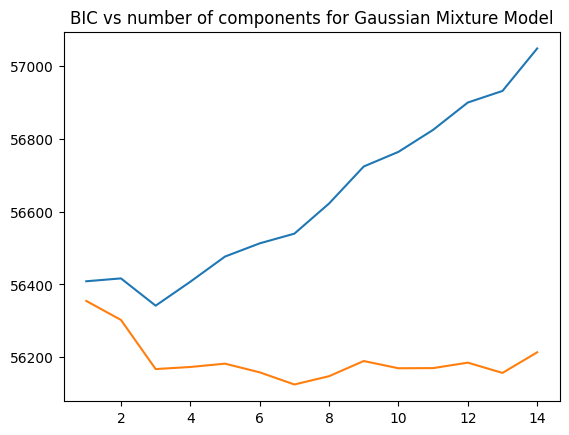

In [12]:
maxrangeN=14 #denotes x which is from 1 to x we check the corresponding paramter models score and test to find optimum N
models = [] #Gaussian mixture of all possible number of components from 1 to max range N
for i in range(maxrangeN):
    models.append(GaussianMixture(n_components=i+1))
    models[i].fit(subset_data) #fitting model with i number of components 
    
BIC = [m.bic(subset_data) for m in models] # Computing BIC for those models
AIC = [m.aic(subset_data) for m in models] # Computing BIC for those models

x = np.linspace(1,maxrangeN,maxrangeN)

plt.plot(x,BIC)
plt.plot(x,AIC)
plt.title("BIC vs number of components for Gaussian Mixture Model")

In [13]:
index = np.argmin(BIC) # computes index of the model with least BIC
optimum_n_model = models[index]
print("best fit converged:", optimum_n_model.converged_)
print("For Least BIC we have optimum number of components as",index+1)

best fit converged: True
For Least BIC we have optimum number of components as 3


In [14]:
index = np.argmin(AIC) # computes index of the model with least BIC
optimum_n_model = models[index]
print("best fit converged:", optimum_n_model.converged_)
print("For Least AIC we have optimum number of components as",index+1)

best fit converged: True
For Least AIC we have optimum number of components as 7


<p>Generally both AIC and BIC criteria give same result in terms of Number of Components required but if they contradict then we consider result with least BIC. Reference - <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html">here</a></p>

In [15]:
gmm = GaussianMixture(n_components=3,random_state=0).fit(subset_data)
labels = gmm.predict(subset_data)
X = np.array(subset_data)

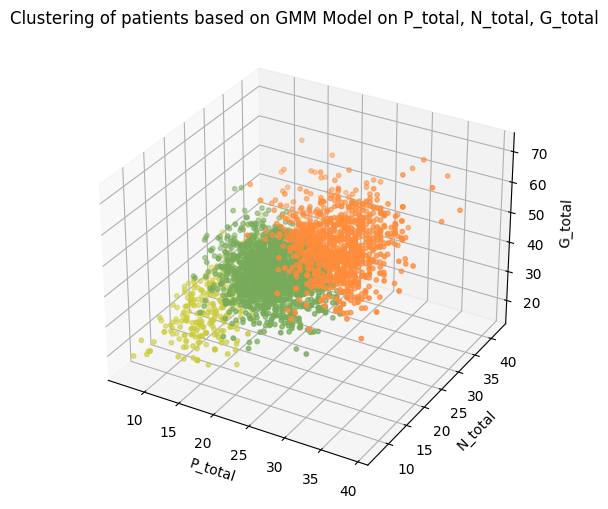

In [16]:
flatui = [(0.8,0.8,0.23), # yellowish-greem color
          (1,0.549,0.23), # orange color
          (0.467,0.670,0.349)] # green color
my_cmap = ListedColormap(flatui)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:,2], c=labels, s=10, cmap=my_cmap)
ax.set_xlabel('P_total')
ax.set_ylabel('N_total')
ax.set_zlabel('G_total')

ax.set_title("Clustering of patients based on GMM Model on P_total, N_total, G_total")
plt.show()

In [24]:
gmm.means_

array([[13.08888181, 20.12583572, 28.61353377],
       [25.57353415, 24.99398799, 48.31773111],
       [19.44639078, 21.70531705, 39.79091547]])

For color (0.8,0.8,0.23) (yellowish-green color) mean of each mixture component is (13.08888181, 20.12583572, 28.61353377), (1,0.549,0.23) (orange color) mean of each mixture component is (1,0.549,0.23) and for (0.467,0.670,0.349) (green color) mean of each mixture component is (19.44639078, 21.70531705, 39.79091547). So orange is shifted towards higher scores and then green, dark-green

#### USING KMeans

In [17]:
scaler = StandardScaler()
scaler.fit(subset_data)
normalised_subset_data = scaler.transform(subset_data) # normalized subset data for algorithms that are sensitive to scale

Text(0.5, 1.0, 'Inertia vs number of components for KMeans Models')

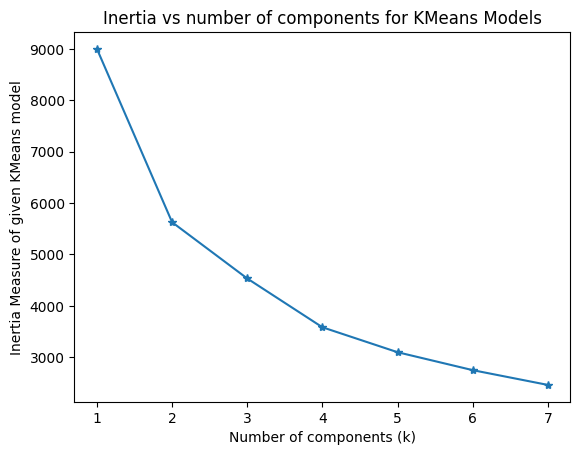

In [18]:
maxrangeN=7 #denotes x which is from 1 to x we check the corresponding paramter models score and test to find optimum N
models = [] # KMeans models of all possible number of components from 1 to max range N
for i in range(maxrangeN):
    models.append(KMeans(n_clusters=i+1,n_init='auto').fit(normalised_subset_data))
    
inertia = [m.inertia_ for m in models] # Computing inertia for those models

x = np.linspace(1,maxrangeN,maxrangeN)

plt.plot(x,inertia,'-*')
plt.xlabel("Number of components (k)")
plt.ylabel("Inertia Measure of given KMeans model")
plt.title("Inertia vs number of components for KMeans Models")

<p>The elbow is at k=4 from the above.</p>

<p>The inertia is not a good performance metric when trying to choose k because it keeps getting lower as we increase k. A more precise approach is to use the silhouette score, which is the mean silhouette coefficient over all the instances.</p>

Text(0.5, 1.0, 'Silhoutte Score vs number of components for KMeans Models')

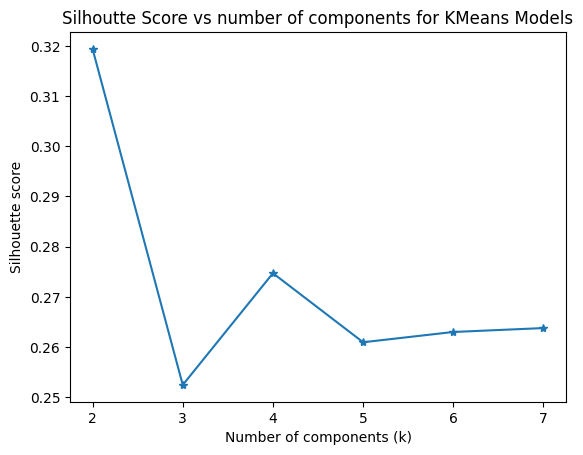

In [19]:
maxrangeN=7 #denotes x which is from 1 to x we check the corresponding paramter models score and test to find optimum N
models = [] # KMeans models of all possible number of components from 1 to max range N
for i in range(maxrangeN-1):
    models.append(KMeans(n_clusters=i+2,n_init='auto').fit(normalised_subset_data))

silhoutte_score = [silhouette_score(normalised_subset_data,m.labels_) for m in models] 
# Computing silhouette scores for those models
x = [2,3,4,5,6,7]
plt.plot(x,silhoutte_score,'-*')
plt.xlabel("Number of components (k)")
plt.ylabel("Silhouette score")
plt.title("Silhoutte Score vs number of components for KMeans Models")

<p>From the above silhouette plot we can conclude that optimal number of components (k) is 2.</p>

In [20]:
# ax.view_init(elev=30, azim=345, roll=120)

kmeans = KMeans(n_clusters=2,n_init='auto',random_state=0).fit(normalised_subset_data)
labels = kmeans.predict(normalised_subset_data)
X = np.array(normalised_subset_data)

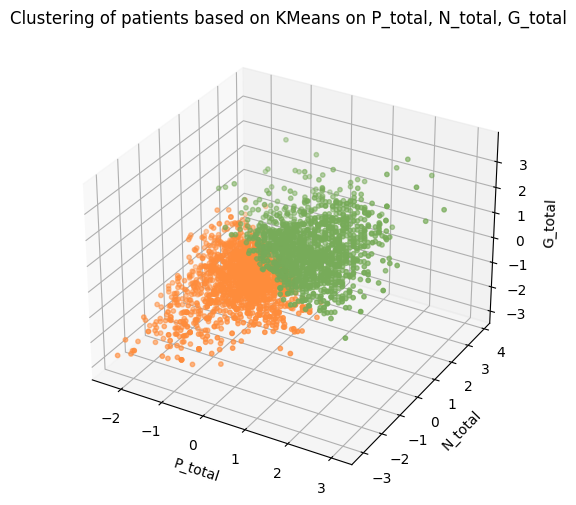

In [21]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')

flatui = [(1,0.549,0.23), # orange
          (0.467,0.670,0.349)]
my_cmap = ListedColormap(flatui)

ax.scatter(X[:, 0], X[:, 1], X[:,2], c=labels, s=10, cmap=my_cmap)
ax.set_xlabel('P_total')
ax.set_ylabel('N_total')
ax.set_zlabel('G_total')

ax.set_title("Clustering of patients based on KMeans on P_total, N_total, G_total")
plt.show()

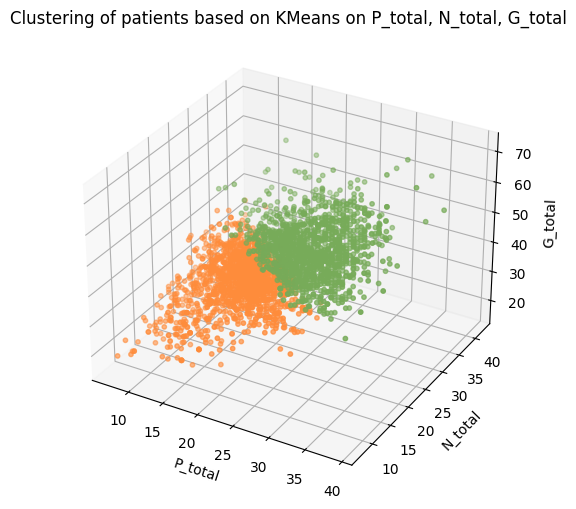

In [22]:
# plotting after inversing the normalisation 
normalised_subset_data = scaler.inverse_transform(normalised_subset_data)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
# ax.view_init(elev=30, azim=345, roll=120)

X = np.array(normalised_subset_data)

ax.scatter(X[:, 0], X[:, 1], X[:,2], c=labels, s=10, cmap=my_cmap)
ax.set_xlabel('P_total')
ax.set_ylabel('N_total')
ax.set_zlabel('G_total')

ax.set_title("Clustering of patients based on KMeans on P_total, N_total, G_total")
plt.show()

In [28]:
scaler.inverse_transform(kmeans.cluster_centers_) # after applying feature scaling

array([[17.08427673, 20.57169811, 35.78805031],
       [24.94326241, 25.01489362, 47.59858156]])

In [29]:
kmeans.cluster_centers_ # normalised data

array([[-0.62277704, -0.41446964, -0.66110499],
       [ 0.70228049,  0.46738066,  0.74550137]])